## Exploratory Data Analysis (EDA) Notebook
This notebook walks through the key steps of Exploratory Data Analysis (EDA) for the historical IFS dataset. Each step includes a short explanation and can be run directly on the training data.

**Data path:** `data/processed/historical_merged/historical_IFS_merged_201702_to_202504.csv`

In [55]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set working directory
os.chdir('C:/Users/jerry/Dropbox/JEREMIAH/MY_STUDIES/DATA_SCIENCE/University_of_Greenwich/Year2/COMP1884 - Group Project/CODE/COMP1884-Group6-Codebase-Complete')

# Load dataset
RAW_DATA_PATH = "data/processed/historical_merged/historical_IFS_merged_201702_to_202504.csv"
df = pd.read_csv(RAW_DATA_PATH, parse_dates=['date'], index_col='date')
df = df.asfreq('h')
df.head()

,temperature_2m,surface_pressure,precipitation,wind_speed_10m
date,,,,
2017-02-01 00:00:00,9.6,1008.2,0.0,14.6
2017-02-01 01:00:00,9.6,1007.4,0.0,14.6
2017-02-01 02:00:00,9.9,1006.8,0.6,15.1
2017-02-01 03:00:00,10.0,1006.5,0.3,15.0
2017-02-01 04:00:00,10.2,1006.2,0.3,15.5


## Step 1: Dataset Overview
Check basic structure, number of rows, columns, data types, and missing values.

In [40]:
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72264 entries, 2017-02-01 00:00:00 to 2025-04-30 23:00:00
Freq: h
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   temperature_2m    72264 non-null  float64
 1   surface_pressure  72264 non-null  float64
 2   precipitation     72264 non-null  float64
 3   wind_speed_10m    72264 non-null  float64
dtypes: float64(4)
memory usage: 2.8 MB


temperature_2m      0
surface_pressure    0
precipitation       0
wind_speed_10m      0
dtype: int64

**INSIGHTS**: No missing values, correct data types

## Step 2: Timestamp Continuity
Ensure that the datetime index has no missing or duplicate entries.

In [41]:
expected_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')
missing_times = expected_range.difference(df.index)
print(f'Number of duplicate timestamps: {df.index.duplicated().sum()}')
print(f'Missing timestamps: {len(missing_times)}')

Number of duplicate timestamps: 0
Missing timestamps: 0


**INSIGHTS**: no gaps or duplicates in timestamps

## Step 3: Feature Distributions
Visualise how each variable is distributed.

In [42]:
from scipy.stats import skew

for col in ['temperature_2m', 'surface_pressure', 'precipitation', 'wind_speed_10m']:
    col_skew = skew(df[col])
    print(f'{col}: skew = {col_skew:.2f}')


temperature_2m: skew = 0.19
surface_pressure: skew = -0.53
precipitation: skew = 7.93
wind_speed_10m: skew = 0.82


**INSIGHTS:**
The skewness analysis reveals that:

- **Temperature** (skew = 0.19) and **surface pressure** (skew = −0.53) are approximately symmetric and require no transformation.
- **Wind speed** (skew = 0.82) is moderately right-skewed; smoothing or robust scaling (e.g. IQR) is advisable.
- **Precipitation** (skew = 7.93) is highly right-skewed with most values near zero. Log transformation (`log1p`) and IQR-based baselines are more appropriate than standard deviation-based methods.

These findings support the use of **robust scaling and non-parametric baselines** for skewed features, especially when preparing inputs for Isolation Forest or sequence-based models.

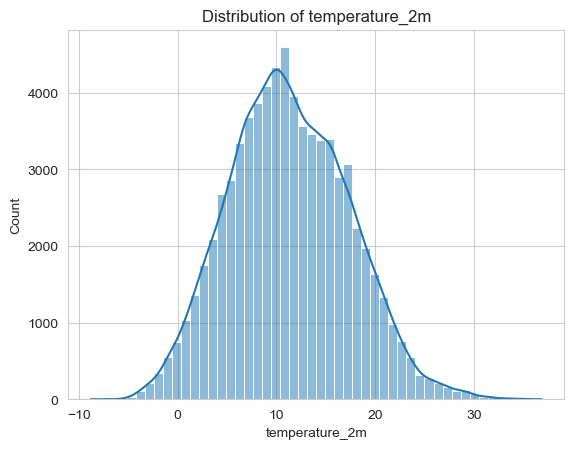

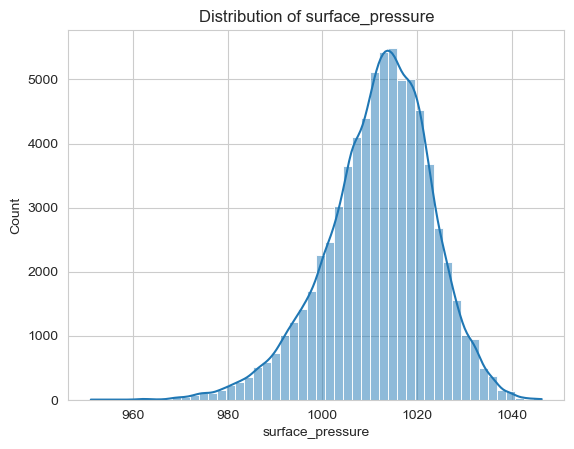

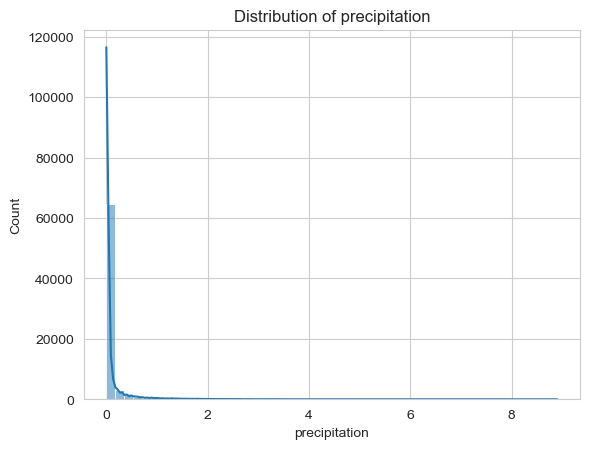

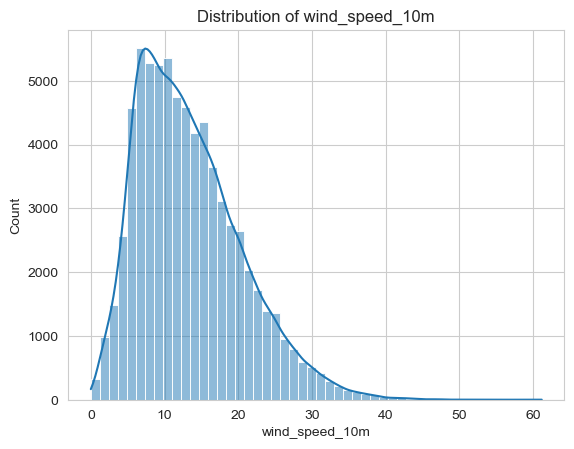

In [43]:
for col in df.columns:
    sns.histplot(df[col], kde=True, bins=50)
    plt.title(f'Distribution of {col}')
    plt.show()

## Step 4: Seasonal and Temporal Trends
Check for **monthly or seasonal patterns** over time.

In [44]:
#add time features
df['month'] = df.index.month
df['year'] = df.index.year
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek # Monday = 0, Sunday = 6
monthly_features = ['temperature_2m', 'surface_pressure', 'precipitation', 'wind_speed_10m']

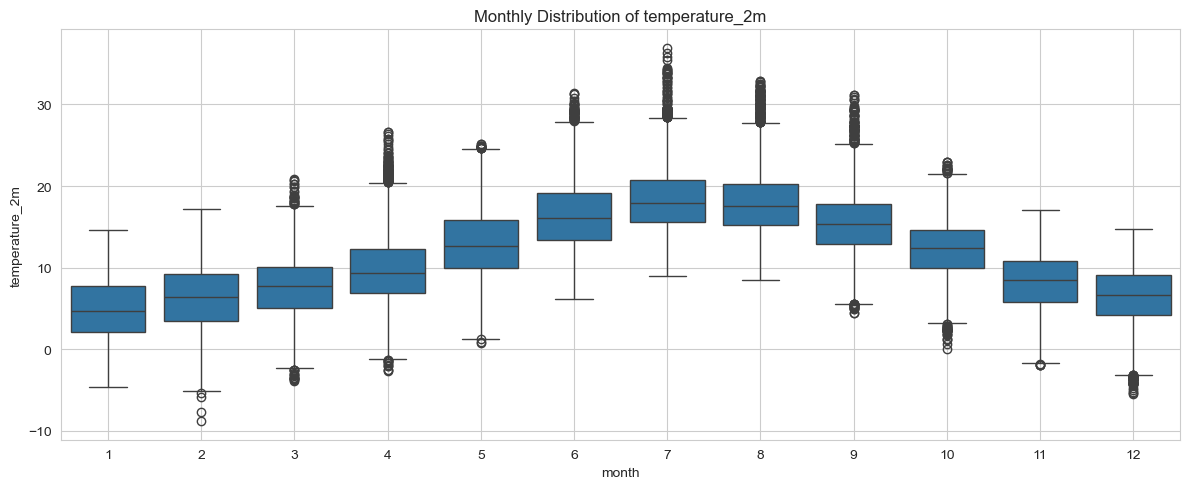

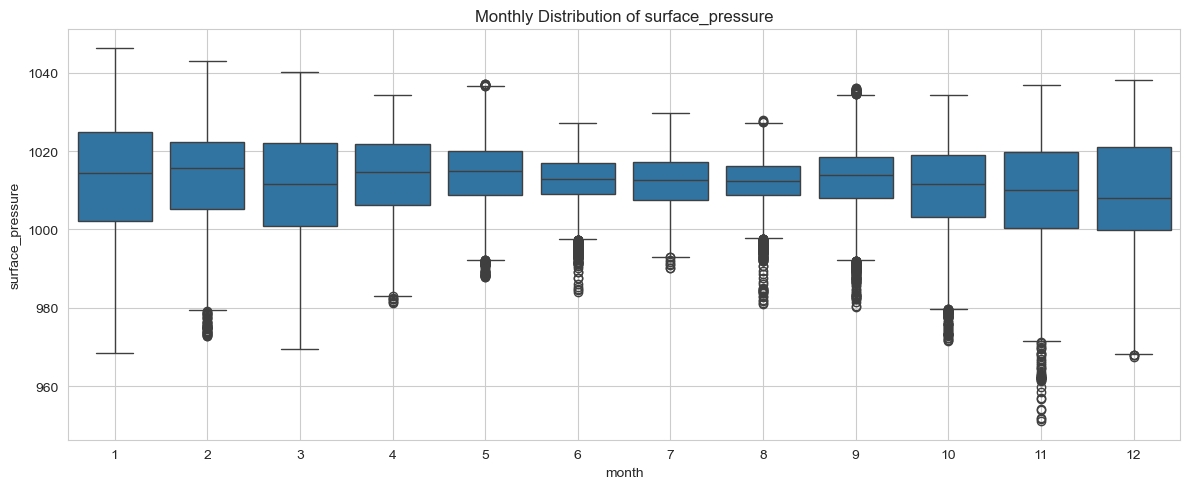

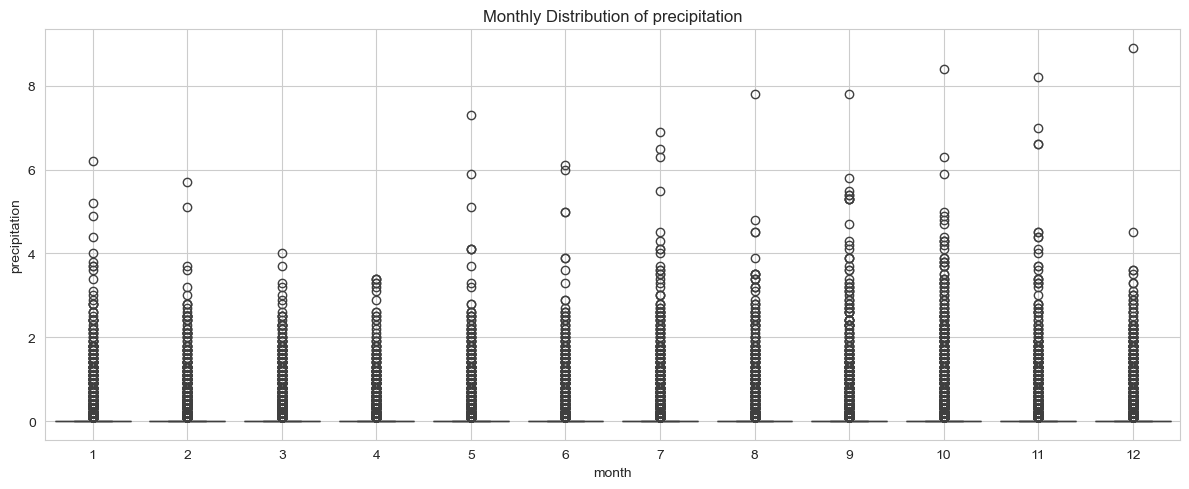

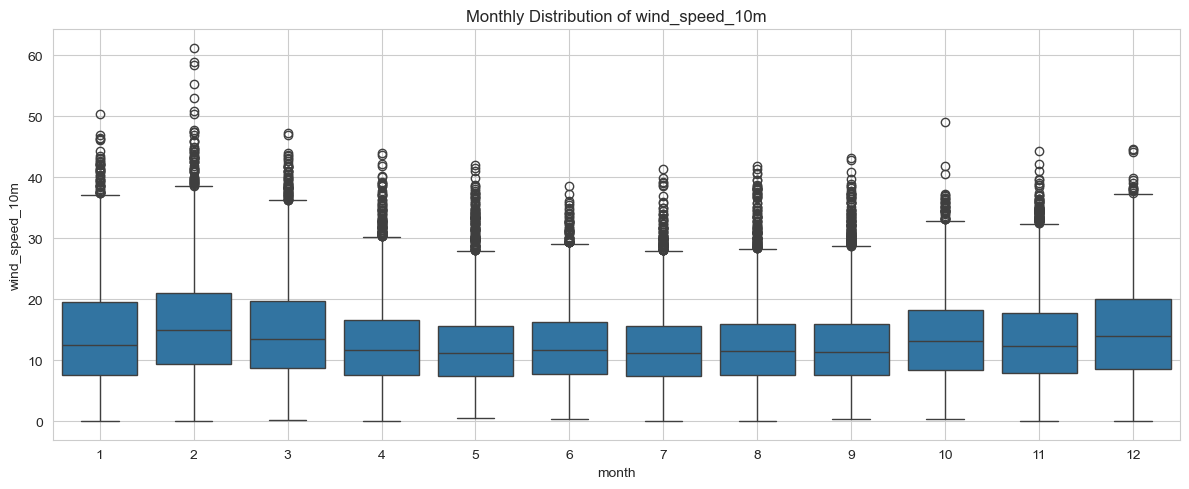

In [45]:
# Monthly box plot (for seasonality)
for col in monthly_features:
    plt.figure(figsize=(12, 5))
    sns.boxplot(data=df, x='month', y=col)
    plt.title(f'Monthly Distribution of {col}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

**INSIGHTS:** Monthly Trends – Key Modelling Insights

- **Temperature**: Strong seasonal pattern → use `month` or cyclical `hour_sin/cos` features.
- **Surface Pressure**: Subtle seasonality with winter variability → effective for detecting low-pressure anomalies.
- **Precipitation**: Highly sparse and right-skewed → apply `log1p()` + IQR-based thresholds.
- **Wind Speed**: Moderate seasonal shift with occasional spikes → rolling IQR or smoothing recommended for anomaly detection.

Seasonal and time-of-day features should be explicitly encoded. Use IQR for skewed variables like precipitation and wind.

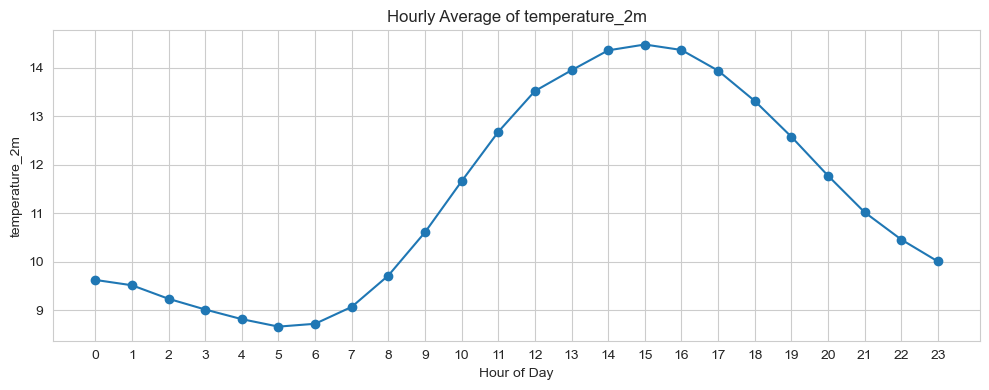

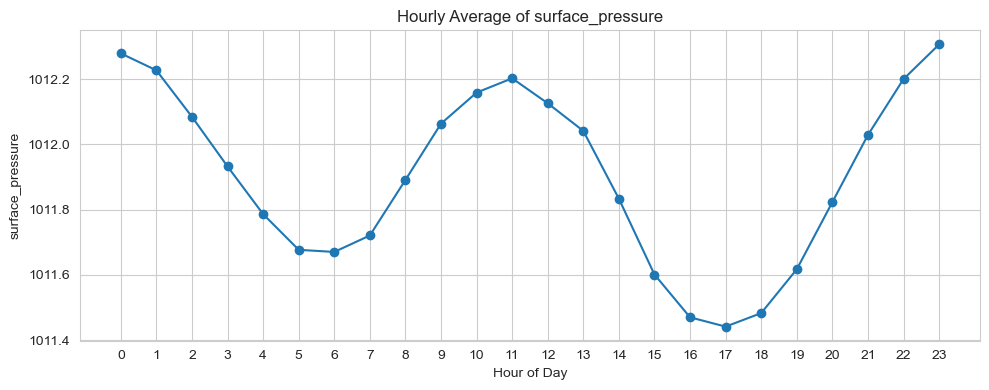

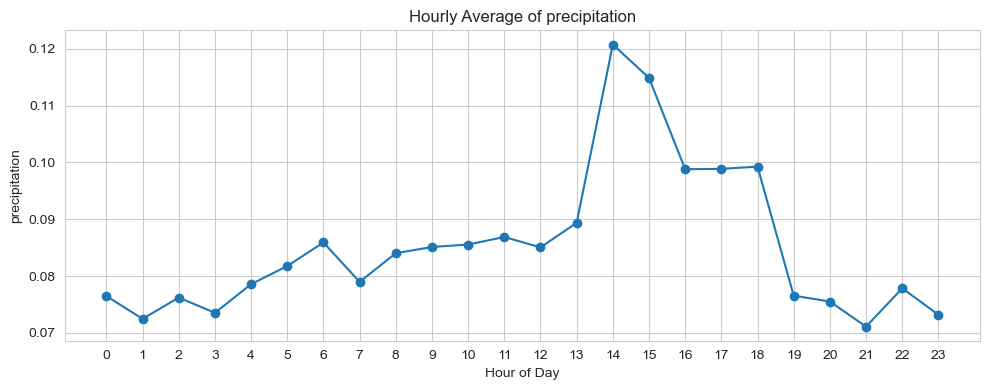

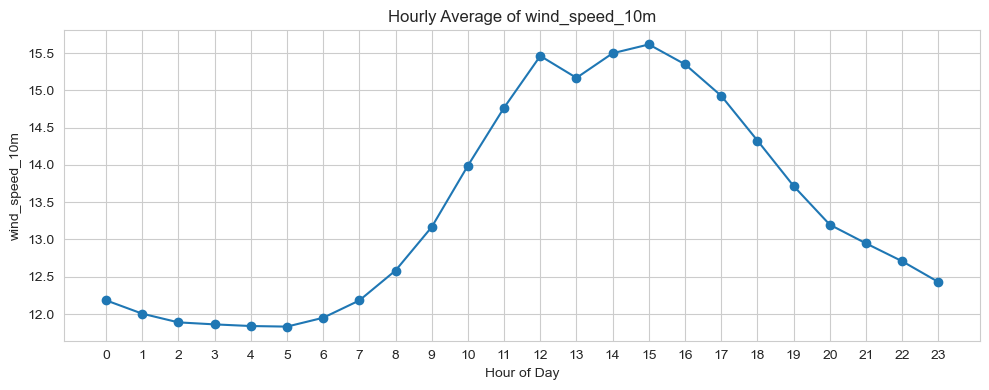

In [46]:
# Plot average value by hour for each variable for diurnal trends
for col in monthly_features:
    hourly_avg = df.groupby('hour')[col].mean()
    plt.figure(figsize=(10, 4))
    hourly_avg.plot(marker='o')
    plt.title(f'Hourly Average of {col}')
    plt.xlabel('Hour of Day')
    plt.ylabel(col)
    plt.xticks(ticks=range(24), labels=[str(h) for h in range(24)])  # Force all 24 ticks
    plt.grid(True)
    plt.tight_layout()
    plt.show()

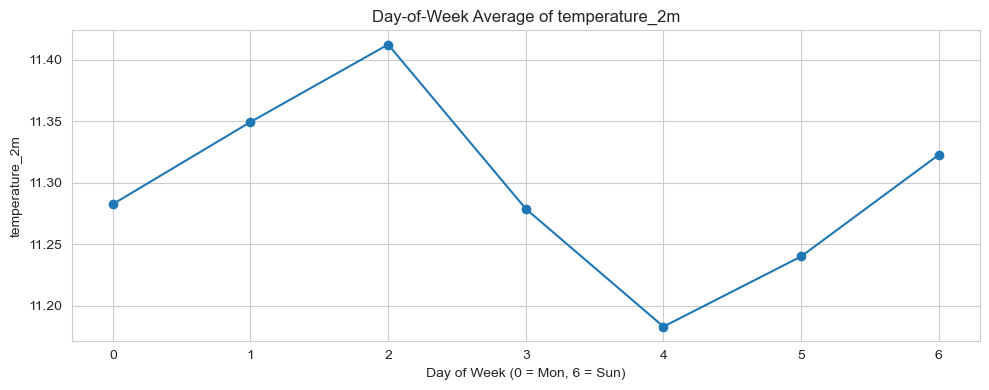

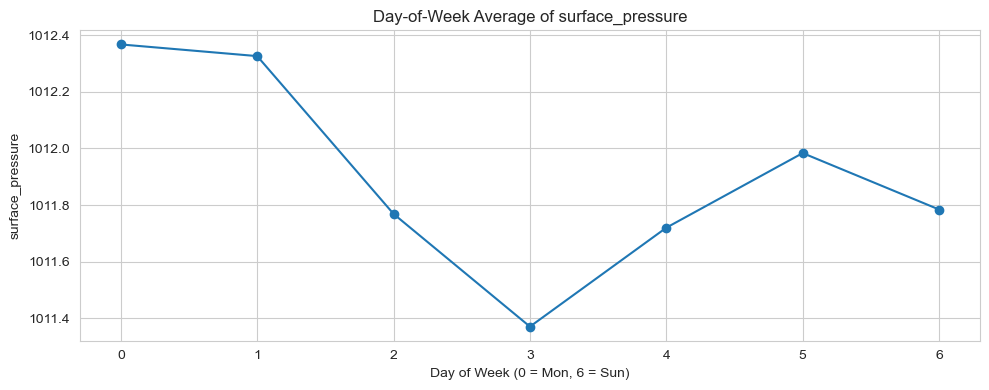

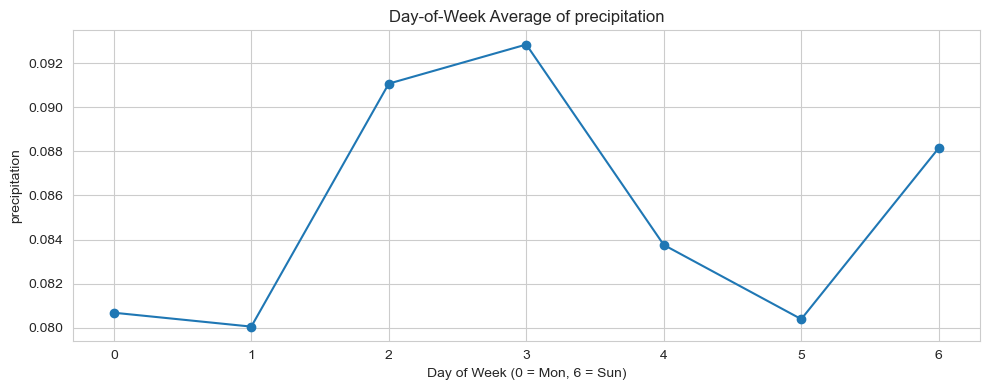

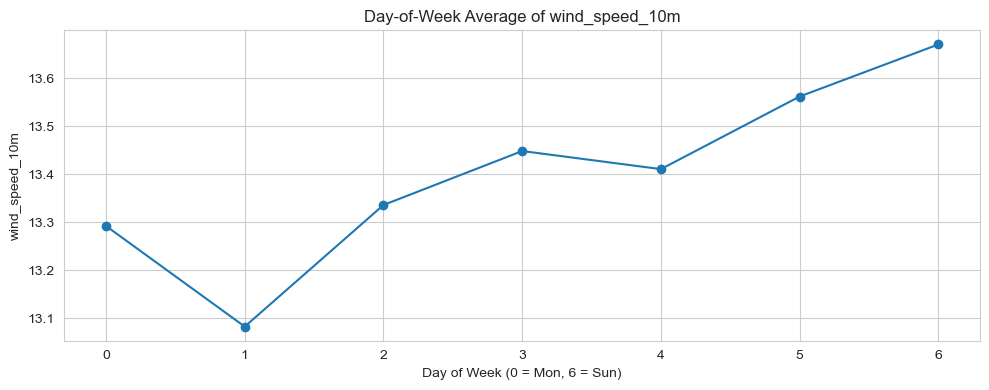

In [47]:
# Day of week patterns
for col in monthly_features:
    dow_avg = df.groupby('dayofweek')[col].mean()
    plt.figure(figsize=(10, 4))
    dow_avg.plot(marker='o')
    plt.title(f'Day-of-Week Average of {col}')
    plt.xlabel('Day of Week (0 = Mon, 6 = Sun)')
    plt.ylabel(col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

**INSIGHTS:**

**Hourly Trends**
- Temperature and wind speed show clear daily cycles, with highest values in the afternoon and lowest around 05:00.
- Surface pressure shows minimal variation across the day.
- Precipitation remains mostly flat but slightly higher in the late afternoon.

**Day-of-Week Trends**
- No meaningful differences are observed for temperature, pressure, or precipitation across the week.
- Wind speed is slightly higher at weekends, but the difference is small.

**Conclusion**
Hourly patterns are useful for feature engineering (e.g. `hour_sin`, `hour_cos`).



## Step 5: Feature Correlation
Use a heatmap to show how features relate to each other.

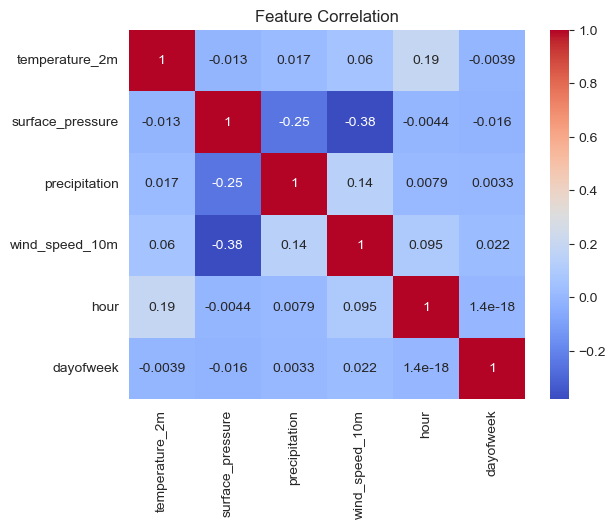

In [48]:
corr = df.drop(columns=['month', 'year']).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Feature Correlation')
plt.show()

**INGISHTS**: Feature Correlation Summary

This chart shows how the four weather features are related to each other:

- **Temperature** has almost no correlation with wind speed, precipitation, or pressure.
- **Surface pressure** has a moderate negative correlation with wind speed (−0.38), and a weaker negative link with precipitation (−0.25).
- **Precipitation** and **wind speed** are only very weakly correlated (+0.14).
- All values are below ±0.4, so there is no strong relationship between any of the features.

**Conclusion**: Each feature adds separate information. This is helpful for anomaly detection, as the models can treat them independently. It also improves explanation clarity when using SHAP or surrogate models.


## Step 6: Rolling Statistics Preview
Compute 60-day rolling mean and standard deviation for visual inspection.

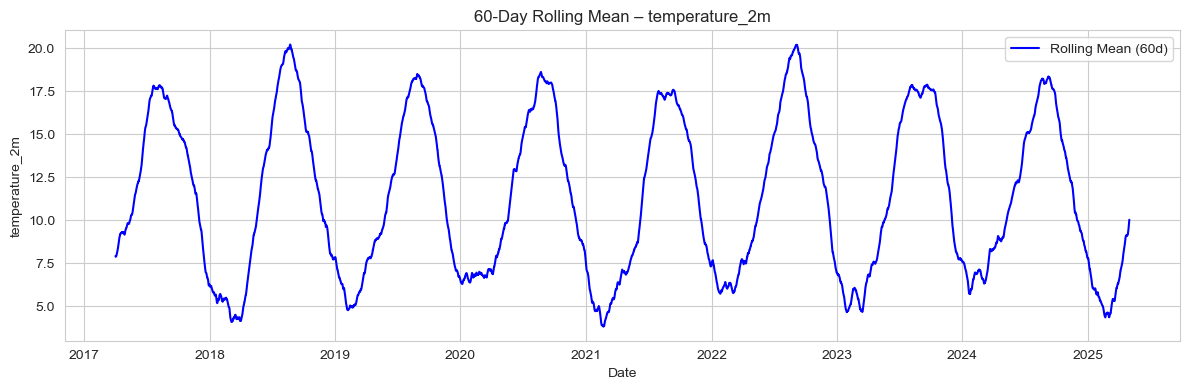

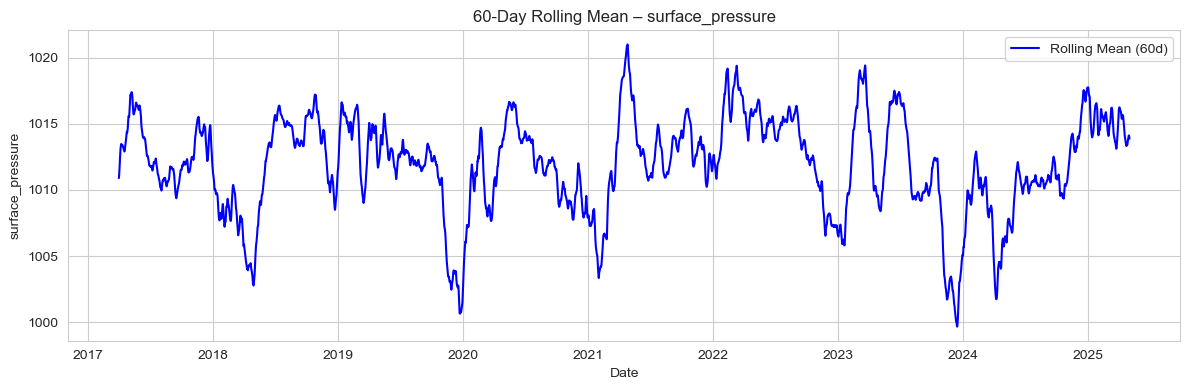

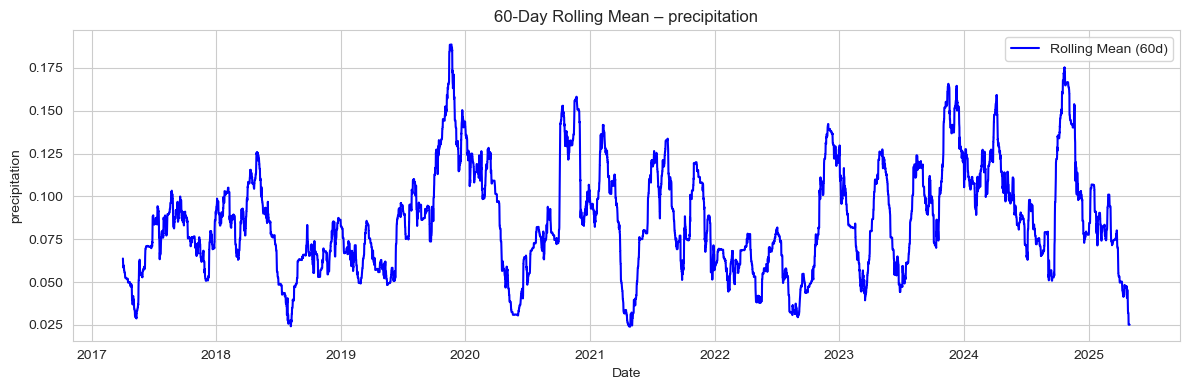

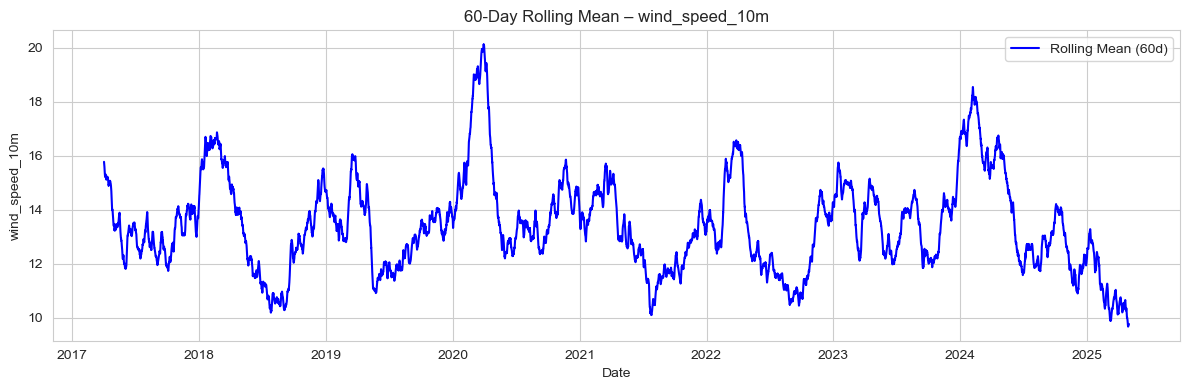

In [54]:
rolling_window = 1440  # 60 days

for col in ['temperature_2m', 'surface_pressure', 'precipitation', 'wind_speed_10m']:
    rolling_mean = df[col].rolling(window=rolling_window).mean()

    plt.figure(figsize=(12, 4))
    plt.plot(df.index, rolling_mean, label='Rolling Mean (60d)', color='blue')
    plt.title(f'60-Day Rolling Mean – {col}')
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

**INSIGHTS:** 60-Day Rolling Mean – Key Insights

- **Temperature**: Stable seasonal pattern, ideal for baseline modelling.
- **Pressure**: Flat trend, suitable for fixed or relative thresholds.
- **Precipitation**: Too sparse for rolling mean, use IQR or spike detection instead.
- **Wind Speed**: Seasonal shape with occasional peaks; use IQR or smoothing.


## Step 7 Advanced Rollings Statistics Preview (Mean & Std Dev based)
Purpose: Visualise what’s considered normal over time for each feature
Method: Plot the actual values along with their 60-day rolling mean and ±2 standard deviation band (using a 1440-hour window)

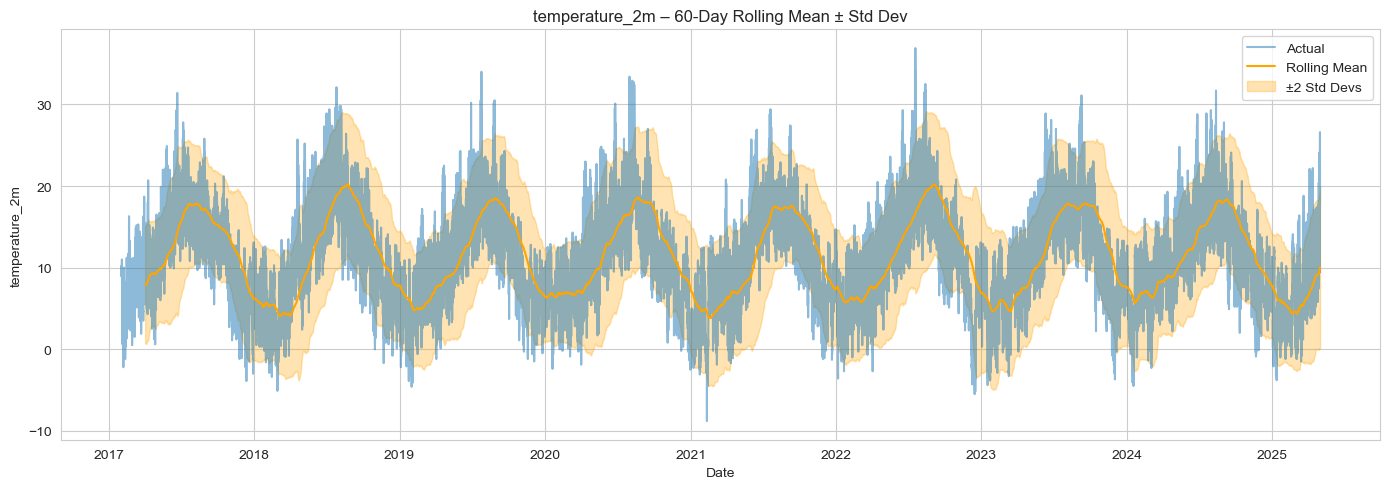

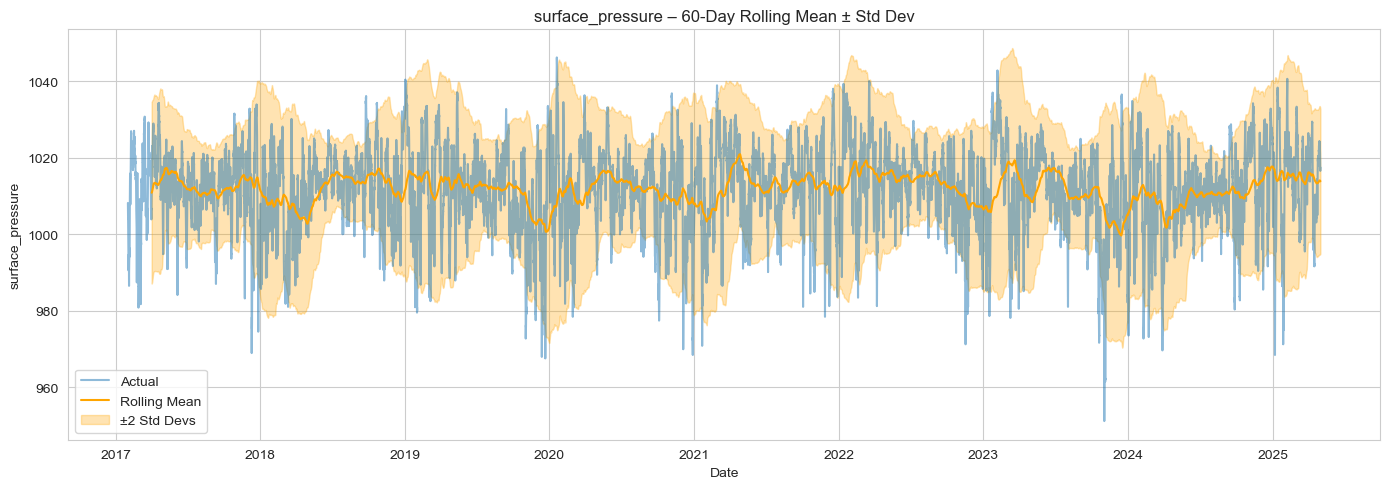

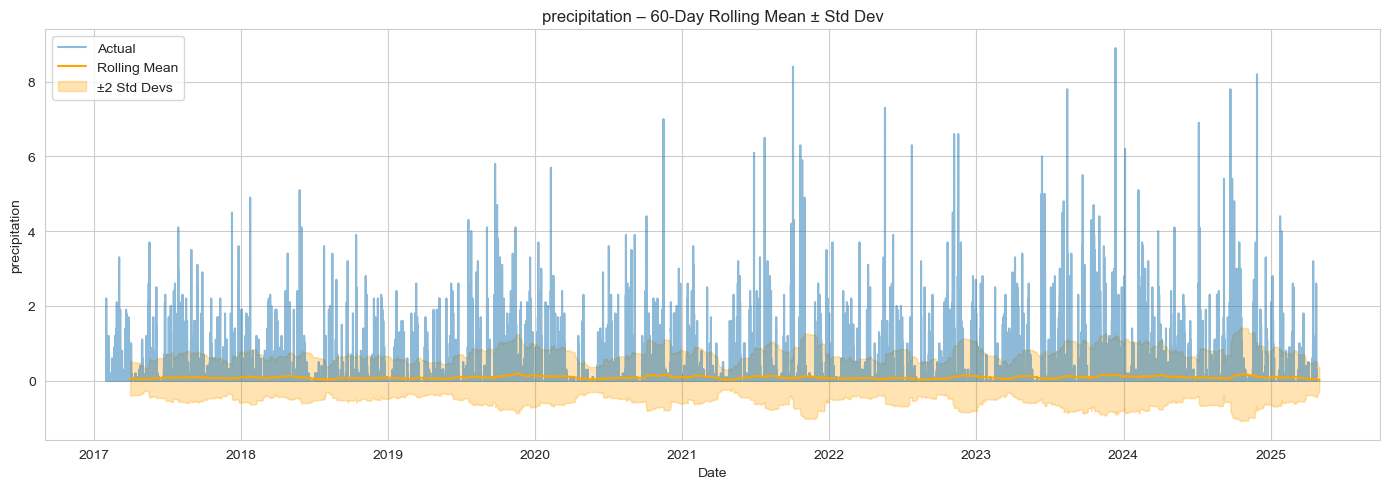

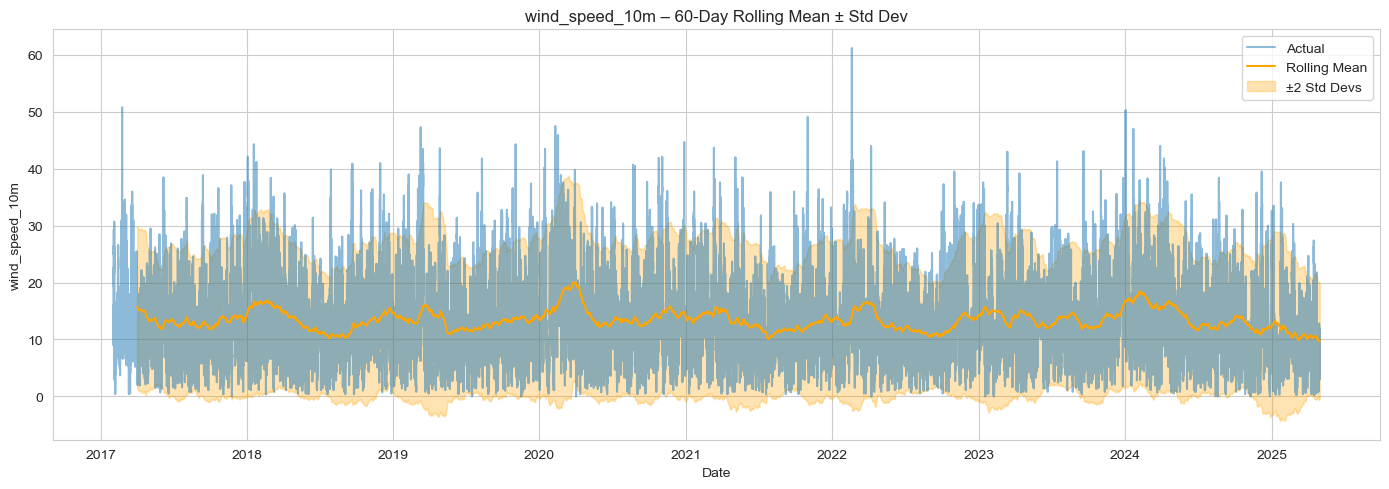

In [50]:
# Set rolling window: 60 days = 1440 hours
window = 1440

# Features to analyse
features = ['temperature_2m', 'surface_pressure', 'precipitation', 'wind_speed_10m']

# Plot rolling mean ± 1 std band for each feature
for col in features:
    rolling_mean = df[col].rolling(window=window).mean()
    rolling_std = df[col].rolling(window=window).std()

    plt.figure(figsize=(14, 5))
    plt.plot(df.index, df[col], label='Actual', alpha=0.5)
    plt.plot(df.index, rolling_mean, label='Rolling Mean', color='orange')
    plt.fill_between(
        df.index,
        rolling_mean - 2*rolling_std,
        rolling_mean + 2*rolling_std,
        color='orange',
        alpha=0.3,
        label='±2 Std Devs'
    )
    plt.title(f'{col} – 60-Day Rolling Mean ± Std Dev')
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

**INSIGHTS:** Rolling Mean ± 2 Std Dev – Key Insights

- **Temperature**: Stable and predictable. Std dev band fits well.
- **Pressure**: Flat and steady. A few dips may be useful as anomalies.
- **Precipitation**: Band is not useful. Most values sit below it. Use other methods.
- **Wind Speed**: Some high spikes. Std dev helps, but IQR may be better.

Conclusion: Std dev works well for temperature and pressure, but not for precipitation or wind.


## Step 7 Advanced Rollings Statistics Preview (ROBUST: Median & IQR)
*Purpose*: Visualise what’s considered normal over time for each feature.
*Method*: Plot the actual values along with their 60-day rolling median and ±1.5 IQR band (using a 1440-hour window)

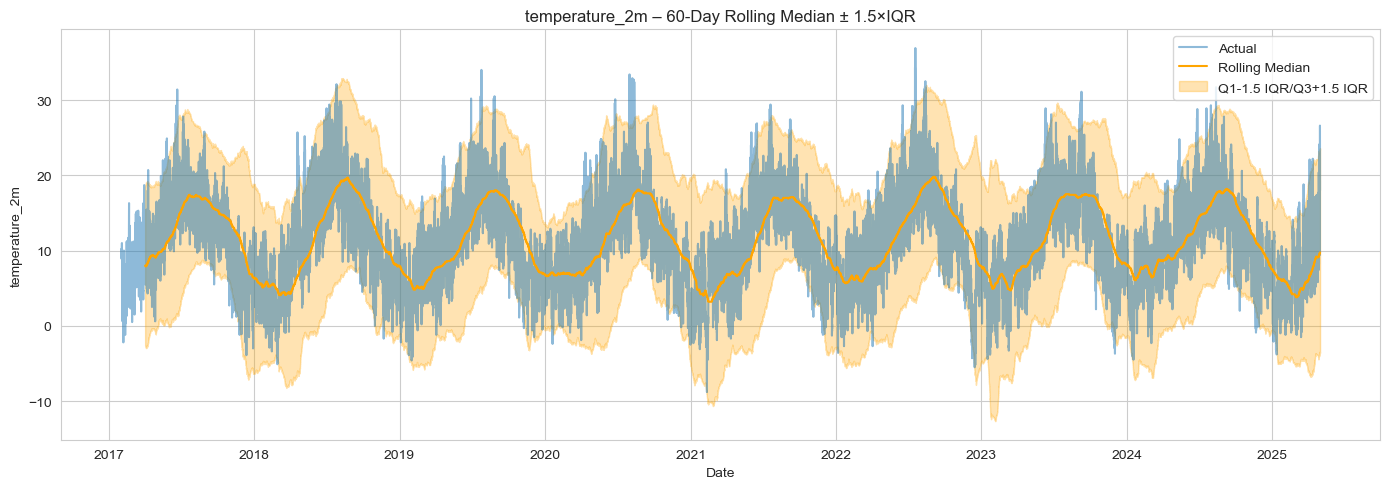

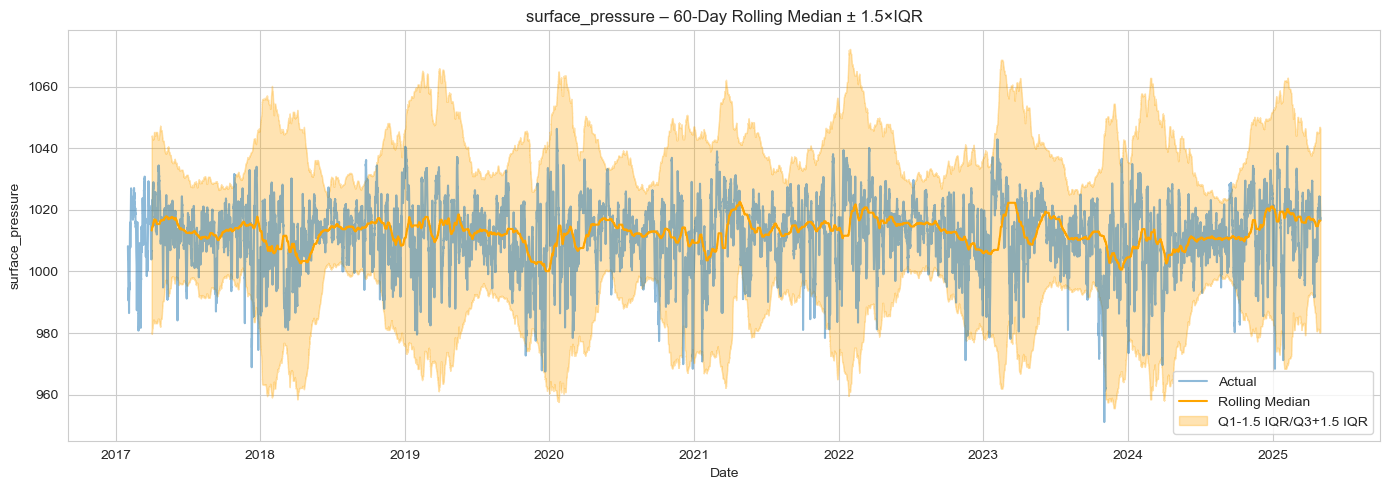

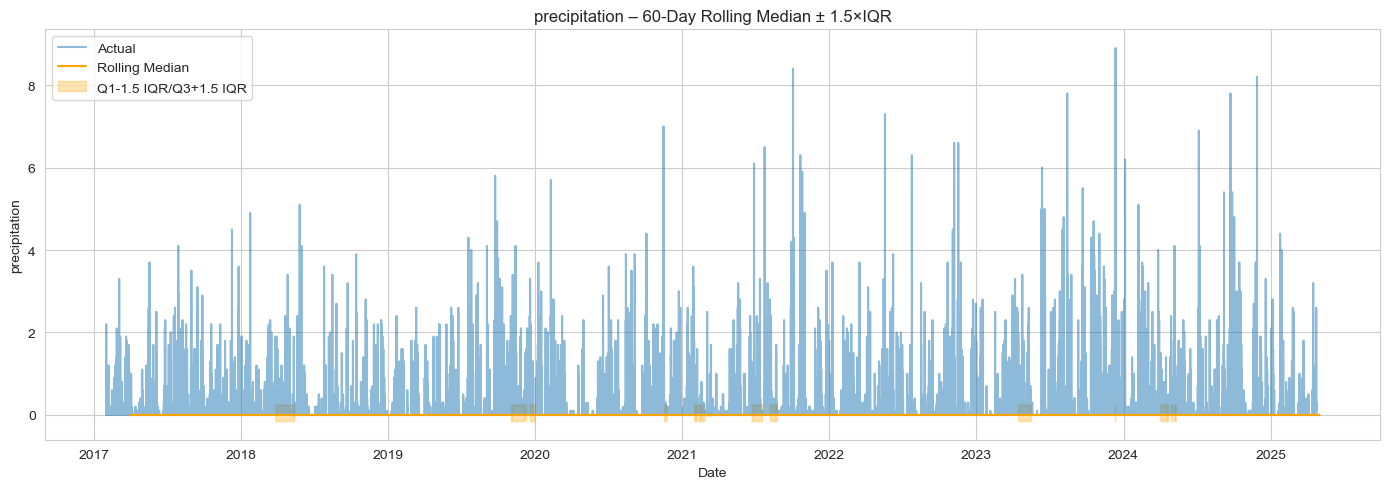

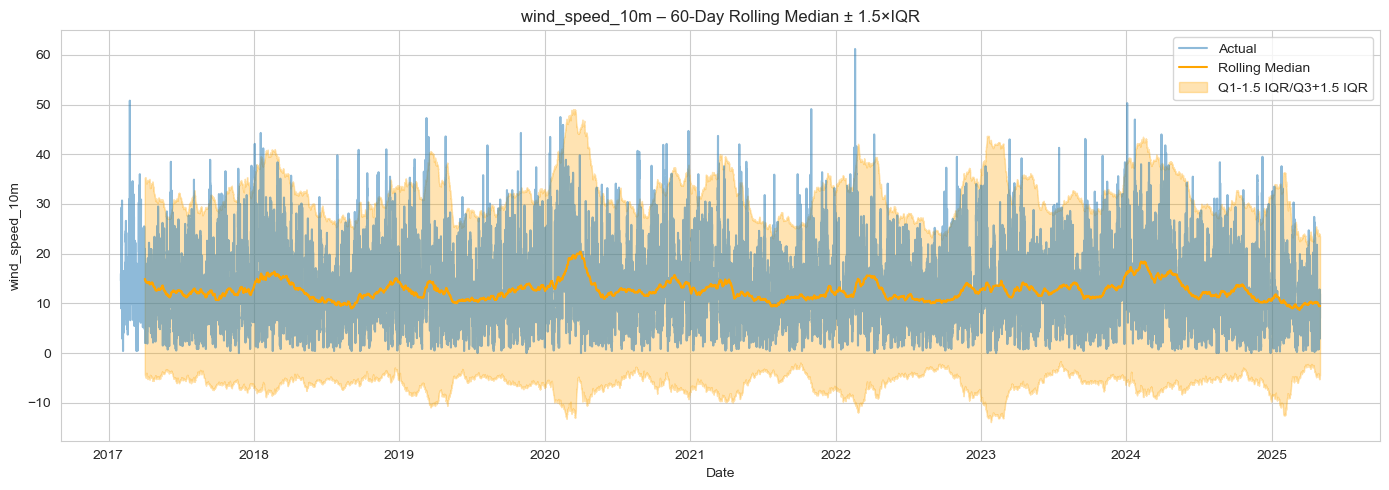

In [51]:
# Set rolling window: 60 days = 1440 hours
window = 1440

# Features to analyse
features = ['temperature_2m', 'surface_pressure', 'precipitation', 'wind_speed_10m']

# Plot rolling median ± 1.5 IQR for each feature
for col in features:
    rolling_median = df[col].rolling(window=window).median()
    rolling_q1 = df[col].rolling(window=window).quantile(0.25)
    rolling_q3 = df[col].rolling(window=window).quantile(0.75)
    rolling_iqr = rolling_q3 - rolling_q1
    lower_band = rolling_q1 - 1.5 * rolling_iqr
    upper_band = rolling_q3 + 1.5 * rolling_iqr

    plt.figure(figsize=(14, 5))
    plt.plot(df.index, df[col], label='Actual', alpha=0.5)
    plt.plot(df.index, rolling_median, label='Rolling Median', color='orange')
    plt.fill_between(
        df.index,
        lower_band,
        upper_band,
        color='orange',
        alpha=0.3,
        label='Q1-1.5 IQR/Q3+1.5 IQR'
    )
    plt.title(f'{col} – 60-Day Rolling Median ± 1.5×IQR')
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

**INSIGHTS:** Rolling Median ± 1.5×IQR – Key Insights

- Temperature and pressure fit well within IQR bands; few mild outliers detected.
- Wind speed shows seasonal shape with some peaks outside the band.
- Precipitation is poorly covered; IQR band is too tight for its spiky nature.
- Consider transforming precipitation (e.g. log1p) before using robust stats.


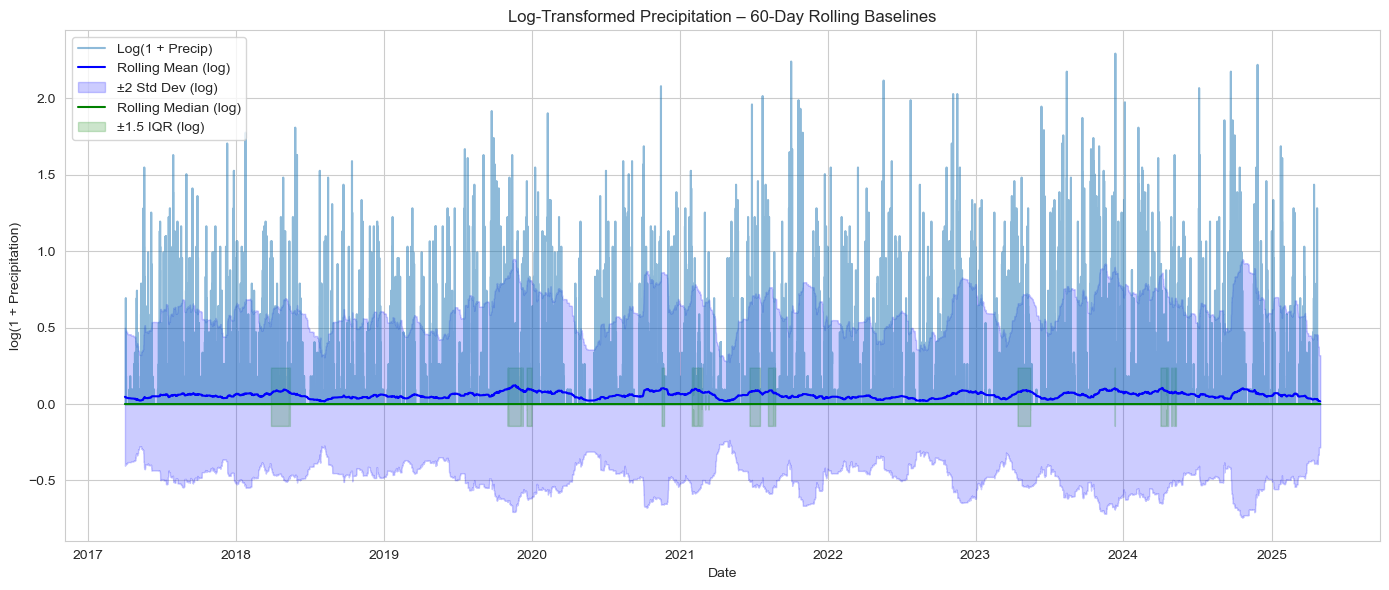

In [57]:
# Preprocess precipitation with log1p transformation
df['precip_log'] = np.log1p(df['precipitation'])

# Recompute rolling bands on log-transformed precipitation
rolling_mean_log = df['precip_log'].rolling(window=window).mean()
rolling_std_log = df['precip_log'].rolling(window=window).std()
mean_lower_log = rolling_mean_log - 2 * rolling_std_log
mean_upper_log = rolling_mean_log + 2 * rolling_std_log

rolling_median_log = df['precip_log'].rolling(window=window).median()
q1_log = df['precip_log'].rolling(window=window).quantile(0.25)
q3_log = df['precip_log'].rolling(window=window).quantile(0.75)
iqr_log = q3_log - q1_log
iqr_lower_log = q1_log - 1.5 * iqr_log
iqr_upper_log = q3_log + 1.5 * iqr_log

# Build clean plotting frame
log_plot_df = pd.DataFrame({
    "value": df['precip_log'],
    "mean": rolling_mean_log,
    "mean_lower": mean_lower_log,
    "mean_upper": mean_upper_log,
    "median": rolling_median_log,
    "iqr_lower": iqr_lower_log,
    "iqr_upper": iqr_upper_log
}).dropna()

# Plot both bands
x = log_plot_df.index.to_numpy()
val = log_plot_df["value"].to_numpy(dtype="float64")
mean = log_plot_df["mean"].to_numpy(dtype="float64")
mean_l = log_plot_df["mean_lower"].to_numpy(dtype="float64")
mean_u = log_plot_df["mean_upper"].to_numpy(dtype="float64")
median = log_plot_df["median"].to_numpy(dtype="float64")
iqr_l = log_plot_df["iqr_lower"].to_numpy(dtype="float64")
iqr_u = log_plot_df["iqr_upper"].to_numpy(dtype="float64")

plt.figure(figsize=(14, 6))
plt.plot(x, val, label='Log(1 + Precip)', alpha=0.5)
plt.plot(x, mean, label='Rolling Mean (log)', color='blue')
plt.fill_between(x, mean_l, mean_u, color='blue', alpha=0.2, label='±2 Std Dev (log)')
plt.plot(x, median, label='Rolling Median (log)', color='green')
plt.fill_between(x, iqr_l, iqr_u, color='green', alpha=0.2, label='±1.5 IQR (log)')
plt.title('Log-Transformed Precipitation – 60-Day Rolling Baselines')
plt.xlabel('Date')
plt.ylabel('log(1 + Precipitation)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

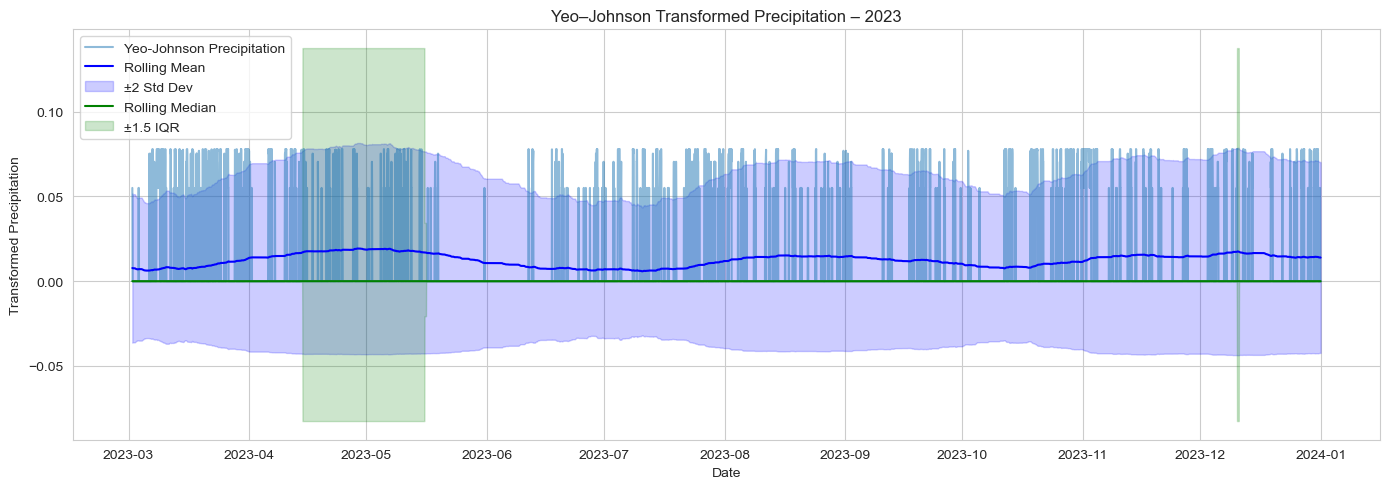

In [61]:
from sklearn.preprocessing import PowerTransformer

# Focus on a single year for clarity (e.g. 2023)
df_2023 = df.loc["2023"].copy()

# Yeo–Johnson transformation (handles 0s and positives)
pt = PowerTransformer(method='yeo-johnson', standardize=False)
df_2023['precip_yeoj'] = pt.fit_transform(df_2023[['precipitation']])

# Compute rolling stats on transformed data
window = 1440
series = df_2023['precip_yeoj']
rolling_mean = series.rolling(window).mean()
rolling_std = series.rolling(window).std()
rolling_q1 = series.rolling(window).quantile(0.25)
rolling_q3 = series.rolling(window).quantile(0.75)
rolling_iqr = rolling_q3 - rolling_q1

# Create bounds
mean_lower = rolling_mean - 2 * rolling_std
mean_upper = rolling_mean + 2 * rolling_std
iqr_lower = rolling_q1 - 1.5 * rolling_iqr
iqr_upper = rolling_q3 + 1.5 * rolling_iqr

# Assemble plotting DataFrame
plot_df = pd.DataFrame({
    'value': series,
    'mean': rolling_mean,
    'mean_lower': mean_lower,
    'mean_upper': mean_upper,
    'median': series.rolling(window).median(),
    'iqr_lower': iqr_lower,
    'iqr_upper': iqr_upper
}).dropna()

# Plot
plt.figure(figsize=(14, 5))
plt.plot(plot_df.index, plot_df['value'], label='Yeo-Johnson Precipitation', alpha=0.5)
plt.plot(plot_df.index, plot_df['mean'], label='Rolling Mean', color='blue')
plt.fill_between(plot_df.index, plot_df['mean_lower'], plot_df['mean_upper'], alpha=0.2, color='blue', label='±2 Std Dev')
plt.plot(plot_df.index, plot_df['median'], label='Rolling Median', color='green')
plt.fill_between(plot_df.index, plot_df['iqr_lower'], plot_df['iqr_upper'], alpha=0.2, color='green', label='±1.5 IQR')
plt.title('Yeo–Johnson Transformed Precipitation – 2023')
plt.xlabel('Date')
plt.ylabel('Transformed Precipitation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**INSIGHTS:** Precipitation – Final Verdict on Rolling Stats

Rolling mean and IQR do not work well for precipitation. Even after transformation, the bands miss many normal values or flag too much.

Instead:
- Use `log1p()` or Yeo–Johnson to reduce skew.
- Do not apply rolling stats for normalisation.
- Let Isolation Forest learn patterns on its own.
- For LSTM-AE, use the transformed value as-is, but only in clean (non-anomalous) sequences.

Conclusion: Rolling stats are not suitable for precipitation. Transformed raw values work better.
